# Mask Detector

## 1) Data Visualisation:

In [1]:
import os
import tensorflow as tf
import datetime
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, save_img
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import shutil
%load_ext tensorboard

path = "/home/idriss/Downloads/Face Mask Dataset/"

In [2]:
print("Images in Train Dataset:")
print("Number of Images for with Mask category:{}".format(len(os.listdir(path+"Train/WithMask"))))
print("Number of Images for with WithoutMask category:{} \n".format(len(os.listdir(path+"Train/WithoutMask/"))))

print("Images in Validation Dataset:")
print("Number of Images for with Mask category:{}".format(len(os.listdir(path+"Validation/WithMask"))))
print("Number of Images for with WithoutMask category:{} \n".format(len(os.listdir(path+"Validation/WithoutMask/"))))

print("Images in Test Dataset:")
print("Number of Images for with Mask category:{}".format(len(os.listdir(path+"Test/WithMask"))))
print("Number of Images for with WithoutMask category:{}".format(len(os.listdir(path+"Test/WithoutMask/"))))

Images in Train Dataset:
Number of Images for with Mask category:5073
Number of Images for with WithoutMask category:5103 

Images in Validation Dataset:
Number of Images for with Mask category:400
Number of Images for with WithoutMask category:400 

Images in Test Dataset:
Number of Images for with Mask category:483
Number of Images for with WithoutMask category:509


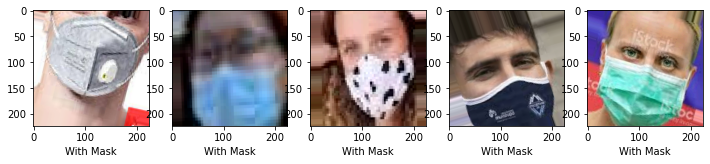

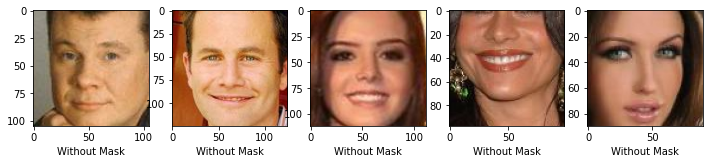

In [3]:
#with Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(path+"Train/WithMask/"))
    plt.subplot(1,5,i+1)
    img = load_img(path+"Train/WithMask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("With Mask")
    plt.imshow(img)
plt.show()

#without Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(path+"Train/WithoutMask/"))
    plt.subplot(1,5,i+1)
    img = load_img(path+"Train/WithoutMask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("Without Mask")
    plt.imshow(img)
plt.show()

## 2) Data Augmentation:

In [109]:
height = 150
width=150
train_dir = path + 'Train'
test_dir = path + 'Validation'
train_datagen = ImageDataGenerator(rescale=1.0/255,validation_split=0.2,shear_range = 0.2,zoom_range=0.2,horizontal_flip=True)
train = train_datagen.flow_from_directory(directory=train_dir,target_size=(height,width),
                                          class_mode="categorical",batch_size=32,subset = "training")

valid_datagen = ImageDataGenerator(rescale=1.0/255)

valid = train_datagen.flow_from_directory(directory=train_dir,target_size=(height,width),
                                          class_mode="categorical",batch_size=32,subset="validation")

Found 8142 images belonging to 2 classes.
Found 2034 images belonging to 2 classes.


## 5) Model Building:

In [59]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2(weights = "imagenet",include_top = False,input_shape=(150,150,3))

In [61]:
for layer in mobilenet.layers:
    layer.trainable = False

In [62]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(2,activation="sigmoid"))

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 64002     
Total params: 2,321,986
Trainable params: 64,002
Non-trainable params: 2,257,984
_________________________________________________________________


In [110]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("moblenet_facemask.h5",monitor="val_accuracy",save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [65]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [66]:
#%tensorboard --logdir logs/fit

In [111]:
history = model.fit_generator(generator=train,steps_per_epoch=len(train)// 32,validation_data=valid,
                             validation_steps = len(valid)//32,callbacks=[tensorboard_callback],epochs=15)

Epoch 1/15
7/7 [==============================] - 10s 1s/step - loss: 0.0655 - accuracy: 0.9866 - val_loss: 0.9352 - val_accuracy: 0.9375
Epoch 2/15
7/7 [==============================] - 8s 1s/step - loss: 0.2382 - accuracy: 0.9821 - val_loss: 1.2014e-07 - val_accuracy: 1.0000
Epoch 3/15
7/7 [==============================] - 9s 1s/step - loss: 0.1098 - accuracy: 0.9911 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 4/15
7/7 [==============================] - 8s 1s/step - loss: 0.2306 - accuracy: 0.9821 - val_loss: 0.1534 - val_accuracy: 0.9844
Epoch 5/15
7/7 [==============================] - 8s 1s/step - loss: 0.1478 - accuracy: 0.9732 - val_loss: 0.1002 - val_accuracy: 0.9531
Epoch 6/15
7/7 [==============================] - 28s 4s/step - loss: 0.1847 - accuracy: 0.9777 - val_loss: 1.2387e-07 - val_accuracy: 1.0000
Epoch 7/15
7/7 [==============================] - 10s 1s/step - loss: 0.3410 - accuracy: 0.9643 - val_loss: 0.7555 - val_accuracy: 0.9531
Epoch 8/15
7/7 [==========

In [77]:
model.save("face_mask.h5")

In [15]:
model = tf.keras.models.load_model("face_mask.h5")

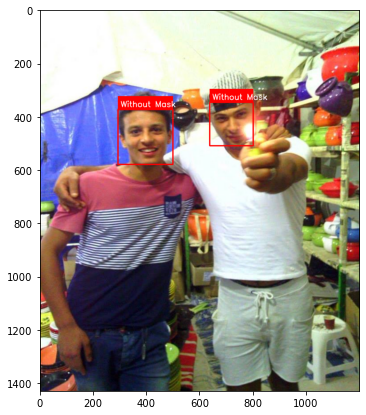

In [216]:
import cv2
plt.figure(figsize=(8,7))
label = {0:"With Mask",1:"Without Mask"}
color_label = {0: (0,255,0),1 : (255,0,0)}
cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
i = "exemples/mask31.jpg"

frame = cv2.imread(i)
if frame.shape[1]<1200:
    u = 1200/frame.shape[1]
    a = int(frame.shape[1] * u)
    b = int(frame.shape[0] + a-frame.shape[1])
else:
    a = frame.shape[1]
    b = frame.shape[0]
frame = cv2.resize(frame,(a,b))
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
faces = cascade.detectMultiScale(gray,1.1,10)
for x,y,w,h in faces:
    face_image = frame[y:y+h,x:x+w]
    resize_img  = cv2.resize(face_image,(150,150))
    normalized = resize_img/255.0
    reshape = np.reshape(normalized,(1,150,150,3))
    reshape = np.vstack([reshape])
    result = model.predict_classes(reshape)

    if result == 0:
        cv2.rectangle(frame,(x,y),(x+w,y+h),color_label[0],3)
        cv2.rectangle(frame,(x,y-50),(x+w,y),color_label[0],-1)
        cv2.putText(frame,label[0],(x+10,y-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        plt.imshow(frame)
    elif result == 1:
        cv2.rectangle(frame,(x,y),(x+w,y+h),color_label[1],3)
        cv2.rectangle(frame,(x,y-50),(x+w,y),color_label[1],-1)
        cv2.putText(frame,label[1],(x+10,y-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        plt.imshow(frame)